# Exploratory statistics : looking beyond the image

Authors: 
- [Médéric FOURMY](https://github.com/MedericFourmy)
- [Nikola LOHINSKI](https://github.com/NikolaLohinski)

<div class="alert alert-info">
In this notebook you will learn how to :
<ul>
<li>[🔗](#1-The-image) **Plot a pnm** image in R
<li>[🔗](#2-Color-distribution) Analyse **color distributions** to get a first sense of the picture 
<li>[🔗](#3-Correlations) Understand the **correlations** between colors and the message they convey
<li>[🔗](#4-Multi-dimensions-analysis) Clusterize elements in the picture using a multi **dimensions analysis** with **K-means** and **hierarchical clustering**
<li>[🔗](#5-Principal-component-analysis) How a **principal component analysis** can be used in this situation
</ul>
</div>

<div class="alert alert-warning">
To run this R-notebook you will need :
<ul>
<li> To have the packages `pixmap`, `corrplot` and `FactoMineR` available. If not, you may run the following cell to install them.
</ul>
</div>


In [ ]:
installed.packages(c('pixmap', 'corrplot', 'FactoMineR'))

Let's start by loading all the packages :

In [ ]:
library(pixmap)
library(corrplot)
library(FactoMineR)

# 1 The image

Several images are available along this notebook in the repository. You may play and test them all, but the analysis and the content of this work was done with a specific picture of a cat, sitting nicely on a pizza ... in space. Let's take a look at it by loading it in `R` for further treatment.

Warning message in rep(cellres, length = 2):
“'x' is NULL so the result will be NULL”

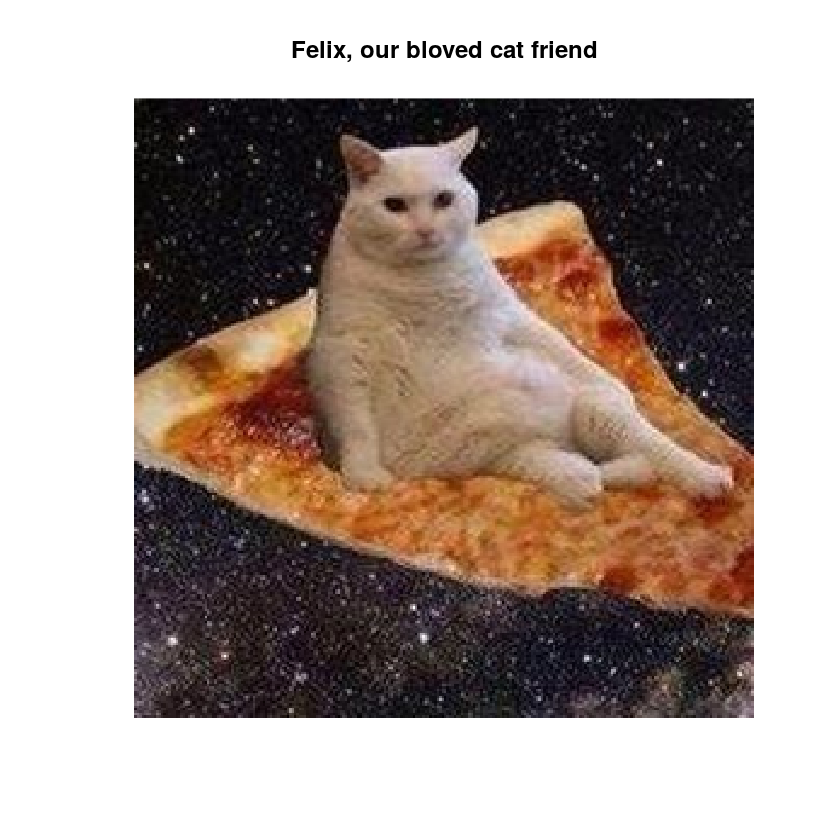

In [2]:
image_path <- 'Data/cat.ppm'

picture <- read.pnm(image_path)
pic_dim <- picture@size[1]

plot(picture, main='Felix, our bloved cat friend')

We will call the cat **Felix**, for no specific reason, and before beginning the analysis, we can already say a few things about the picture :
- The cat is obviously white, the pizza of a reddish-orange and the space black with faints of purple.
- The picture is (obviously) not a real picture, but was handcrafted by adding the cat on the pizza, and then putting both of them in a space like background. However, a certain effort was put in the combination of colors to mix everything together.
Those two remarks may sound/look stupid but they will come back a little bit later and it is important to keep in mind what we are dealing with, and in this case, a _pizzastrocat_.

## 2 Color distribution

Let's take a look at the color distribution keeping in mind the previous remarks :

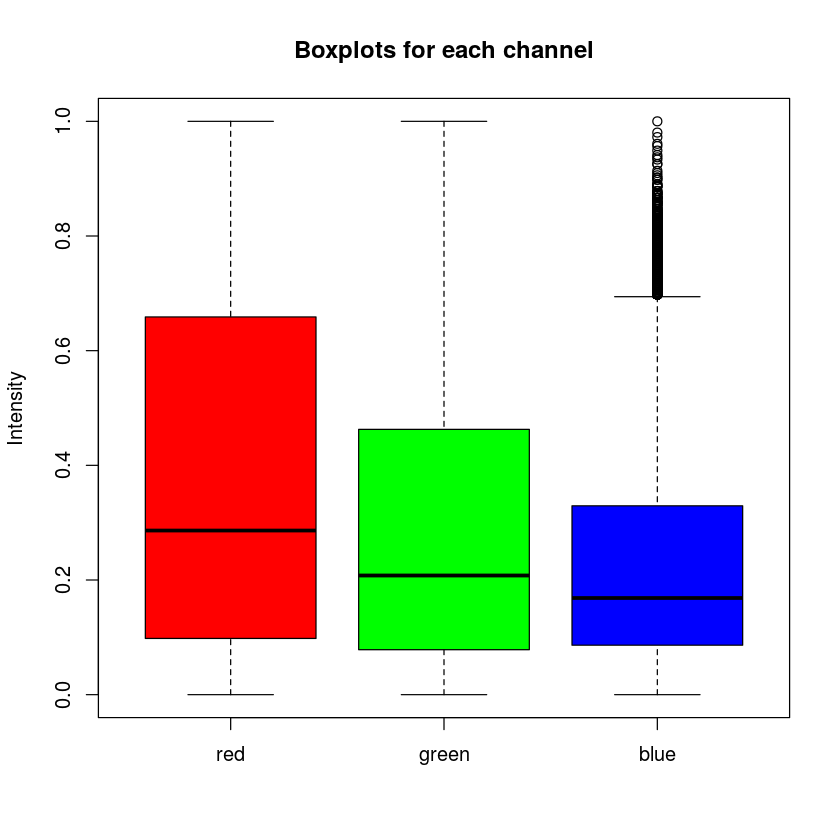

In [3]:
color_names <- c('red', 'green', 'blue')

colors <- data.frame(
    red=as.vector(picture@red),
    green=as.vector(picture@green),
    blue=as.vector(picture@blue)
)

boxplot(colors, col=color_names, ylab='Intensity', main='Boxplots for each channel')

The picture is pretty dark, and the pizza is very red and occupies a big portion of it, which is coherent with those values. There are still a lot of blue outlayers : are they related to the space, or the cat somehow ? Where is the cat in this distribution ? A big white cat should pull the distributions towards 1.0. In fact, even if Felix _looks white_, he is not white. Let's take a closer look by plotting the density plots :

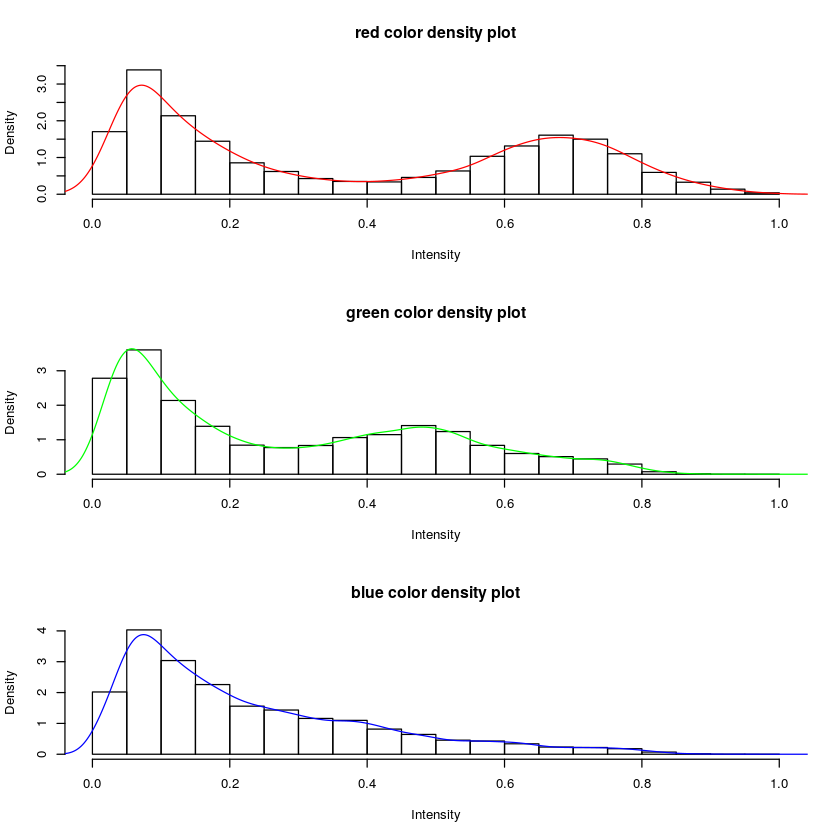

In [4]:
par(mfrow=c(3, 1))
for (col in color_names) {
    hist(
        colors[,col],
        freq=F,
        xlab='Intensity',
        main=sprintf('%s color density plot', col)
    )
    lines(density(colors[,col]), col=col)
}

Nothing new here but the fact that there is almost nothing white in the picture, but some bright red dots, and some unknown _greenish_ spots shows that the colors are not what they seem to be.

Let's try to isolate the colors :

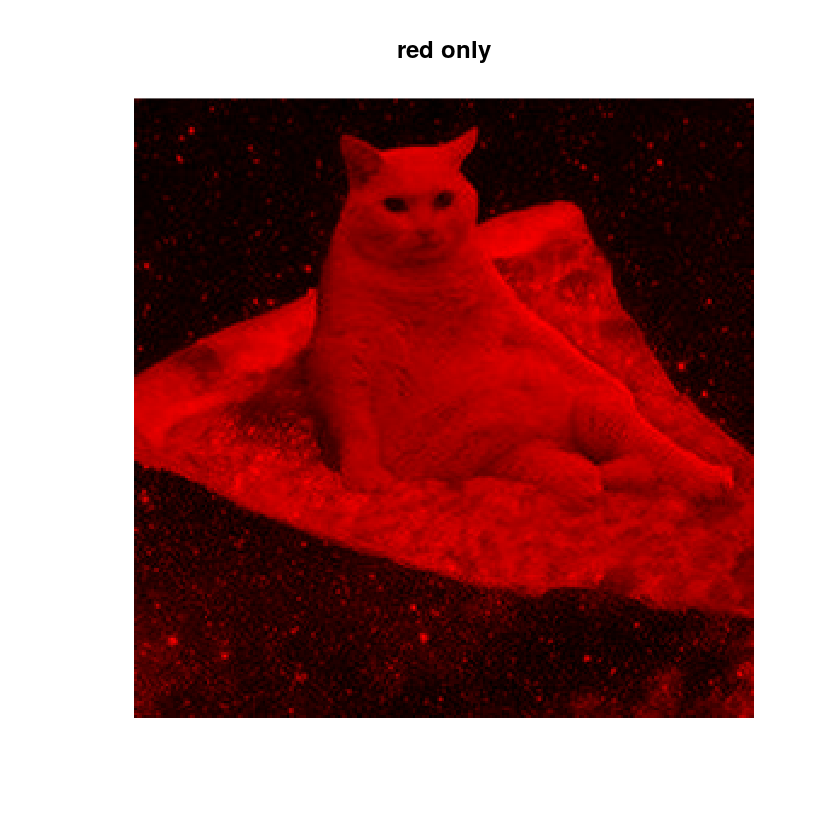

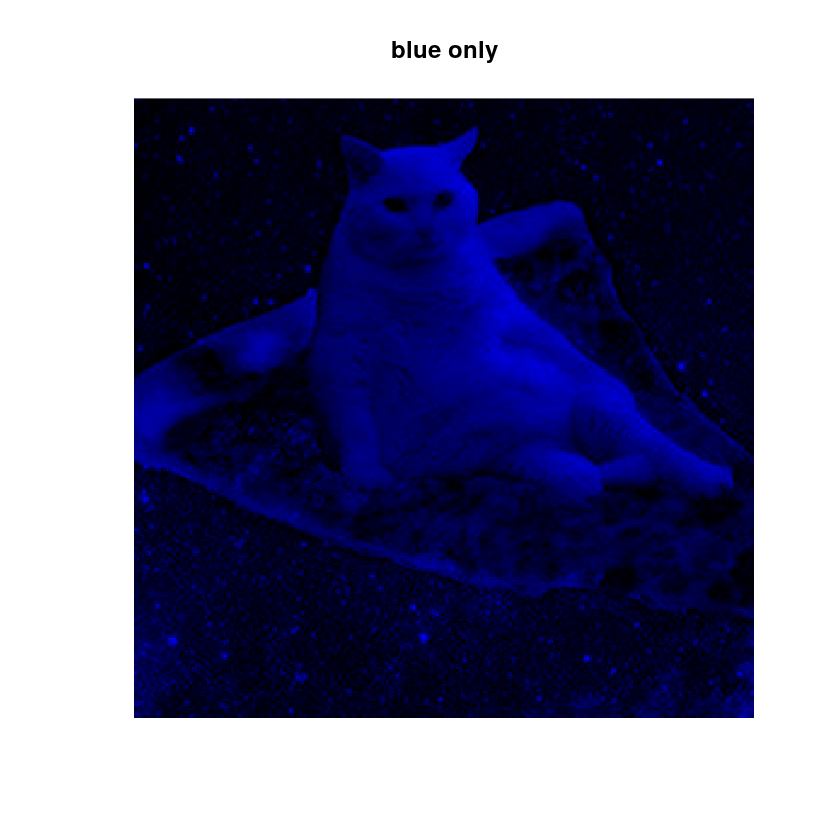

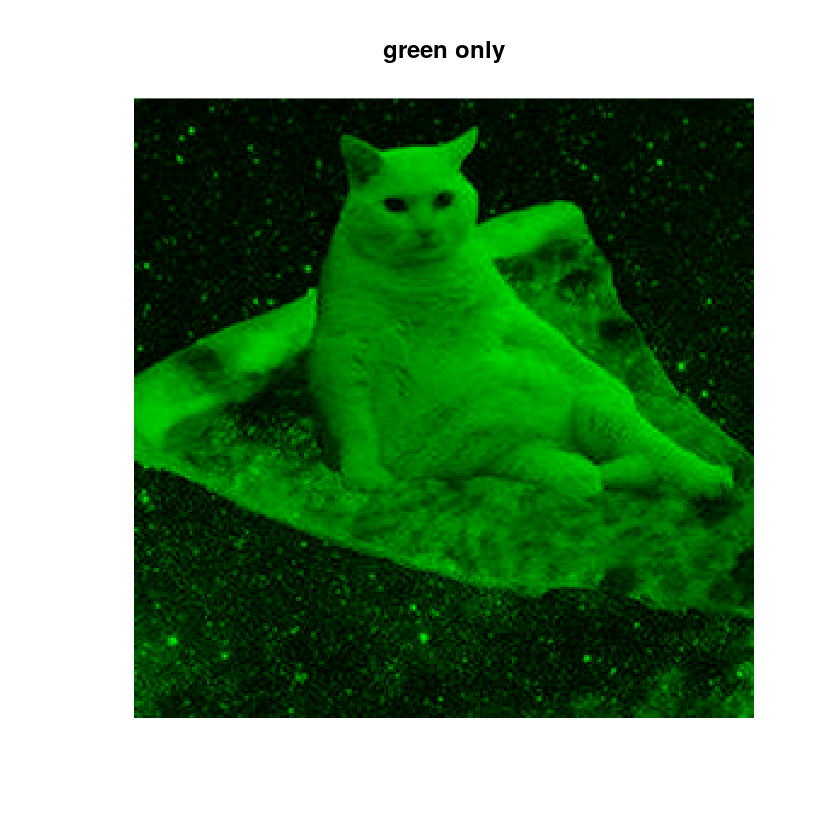

In [5]:
# Red only
red_only <- picture
red_only@green = matrix(data=0, nrow=pic_dim, ncol=pic_dim)
red_only@blue = matrix(data=0, nrow=pic_dim, ncol=pic_dim)
plot(red_only, main='red only')

# Blue only
blue_only <- picture
blue_only@green = matrix(data=0, nrow=pic_dim, ncol=pic_dim)
blue_only@red = matrix(data=0, nrow=pic_dim, ncol=pic_dim)
plot(blue_only, main='blue only')

# Green only
green_only <- picture
green_only@red = matrix(data=0, nrow=pic_dim, ncol=pic_dim)
green_only@blue = matrix(data=0, nrow=pic_dim, ncol=pic_dim)
plot(green_only, main='green only')

Still nothing really new here, but if we look closer at the red image, and filter out darker spots, we get a new information :

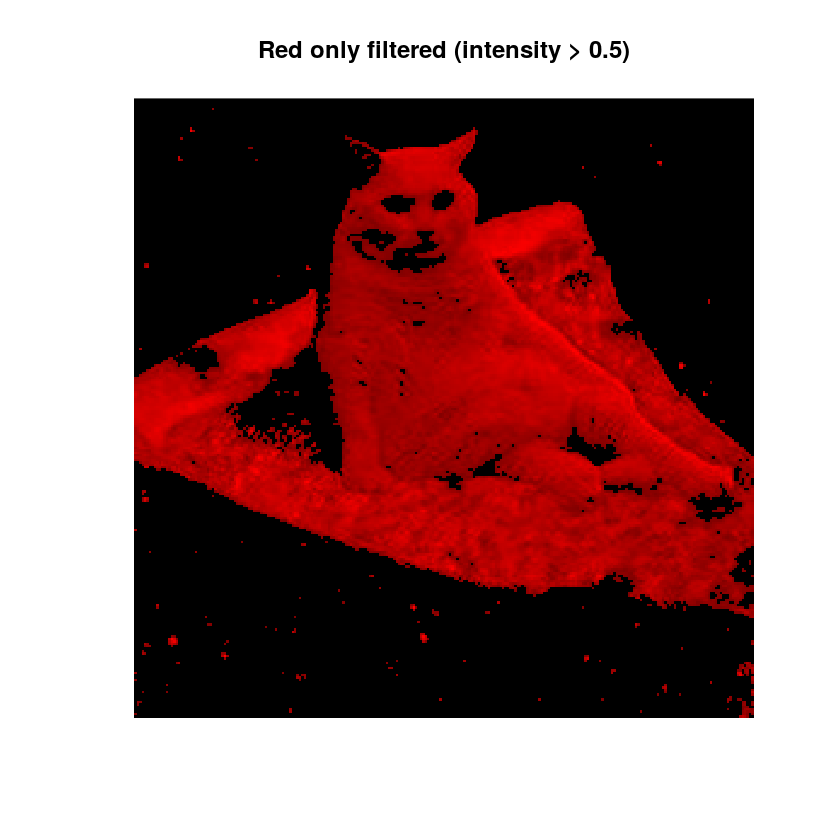

In [6]:
red_only@red[red_only@red < 0.5] <- 0
plot(red_only, main='Red only filtered (intensity > 0.5)')

We know see that there was some work done on the shade of Felix. The light seems to be coming from the right, which was not clear on the original image.

With this first basic analysis, we already found out that the colors play different parts in the image. The red seems to be leading, and the cat is definitely not white. Let's now see how we can correlate the colors.

## 3 Correlations

Let us plot the _corrplot_ for each pair of colors.

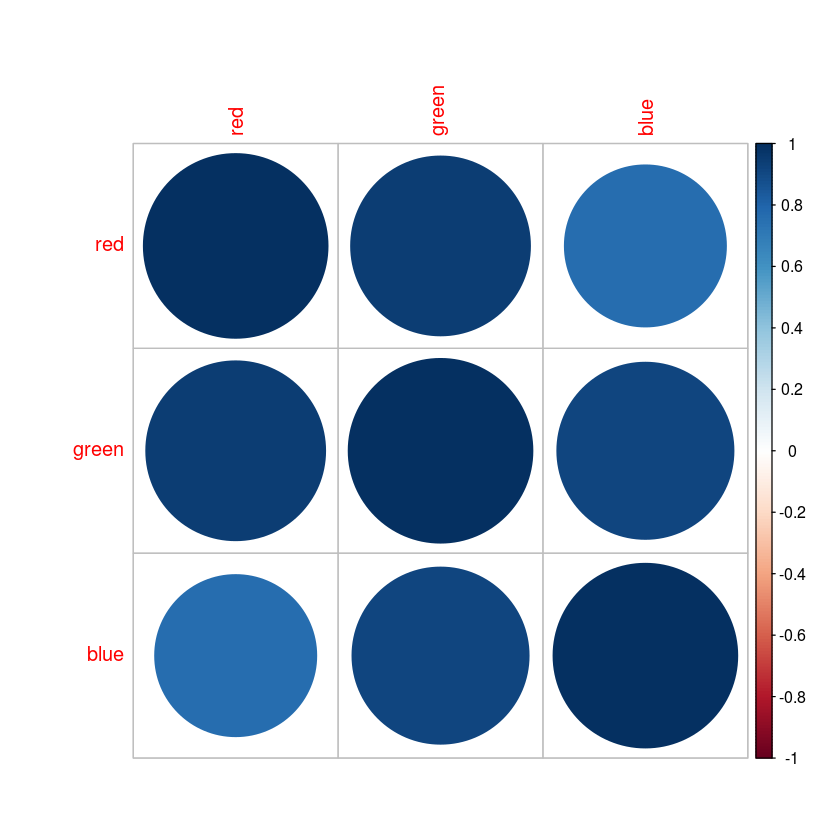

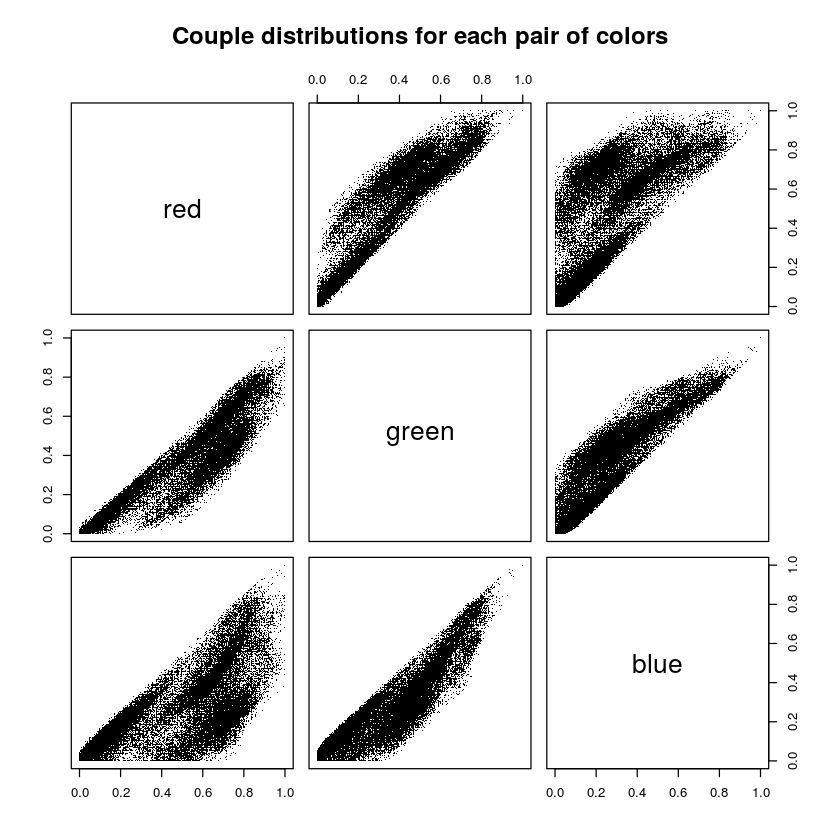

In [7]:
correlations = cor(colors)
corrplot(correlations)
plot(colors, pch='.', main='Couple distributions for each pair of colors')

As we can see, the colors are strongly correlated, the blue a little less in particular. In fact, all the blue comes from the space, and the cat and pizza hold the other colors. Moreover, it seems that all the components of the picture (cat, space, pizza) having been mixed pretty well with regards to the correlations. If we try replacing the cat by a blue fish :

Warning message in rep(cellres, length = 2):
“'x' is NULL so the result will be NULL”

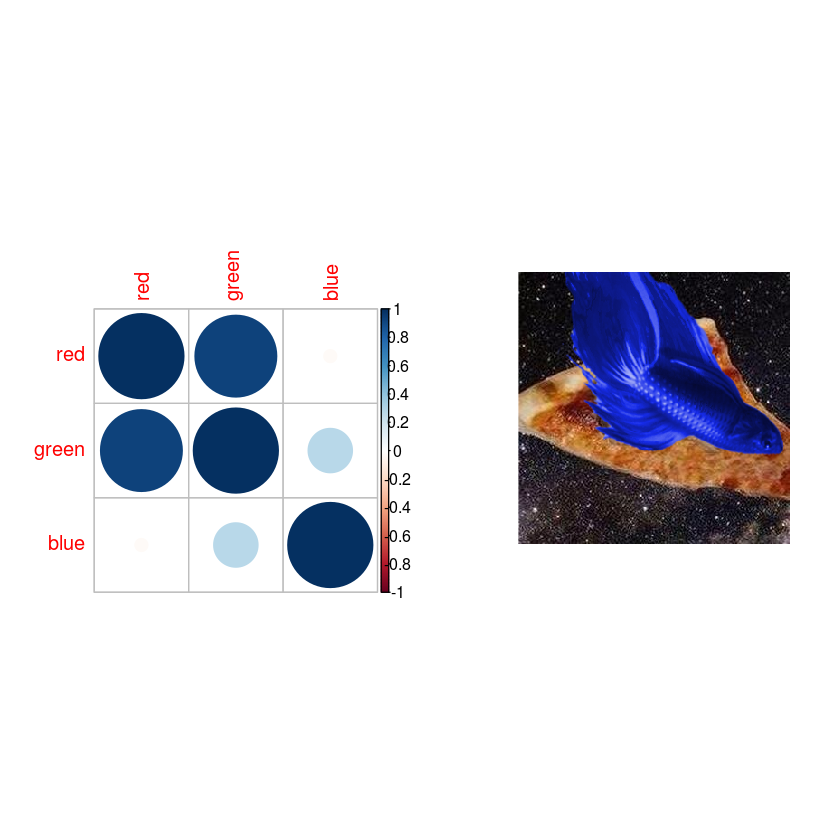

In [8]:
bluefish = read.pnm('Data/fish.ppm')
bluefish_colors <- data.frame(
    red=as.vector(bluefish@red),
    green=as.vector(bluefish@green),
    blue=as.vector(bluefish@blue)
)
bluefish_correlations = cor(bluefish_colors)
par(mfrow=c(1, 2))
corrplot(bluefish_correlations)
plot(bluefish)

We now see that the blue is not related anymore to the rest of the picture. Such an anlysis done more thoughroughly on a real picture could help to determine fake photo editings for instance.

## 4 Multi dimensions analysis

In this part, we will try to clusterize the points of the image in order to separate the different elements of the picture.

### 4.1 K-means

The K-means algorithm is a basic algorithm to build clusters with a defined number of centroids. Given an input vector of centers and a metric, it builds the clusters for those centers using the metric, then re-computes the centroids of the new clusters, and then again re-builds the clusters and so on until it reaches a stationnary state.

Let us see the results for 2, 3, 4 and 8 clusters.

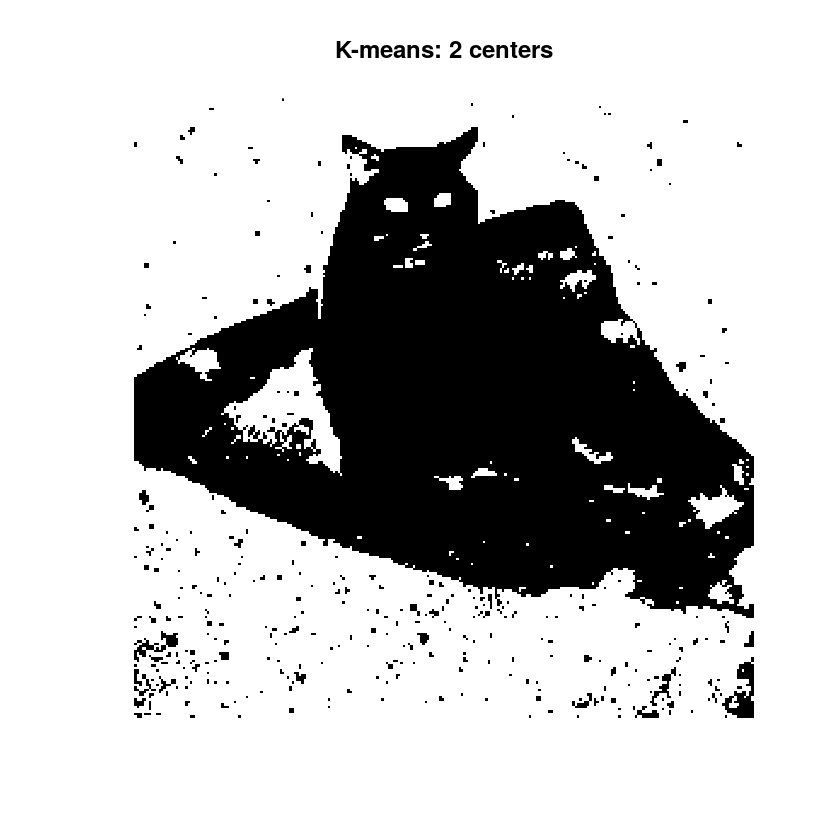

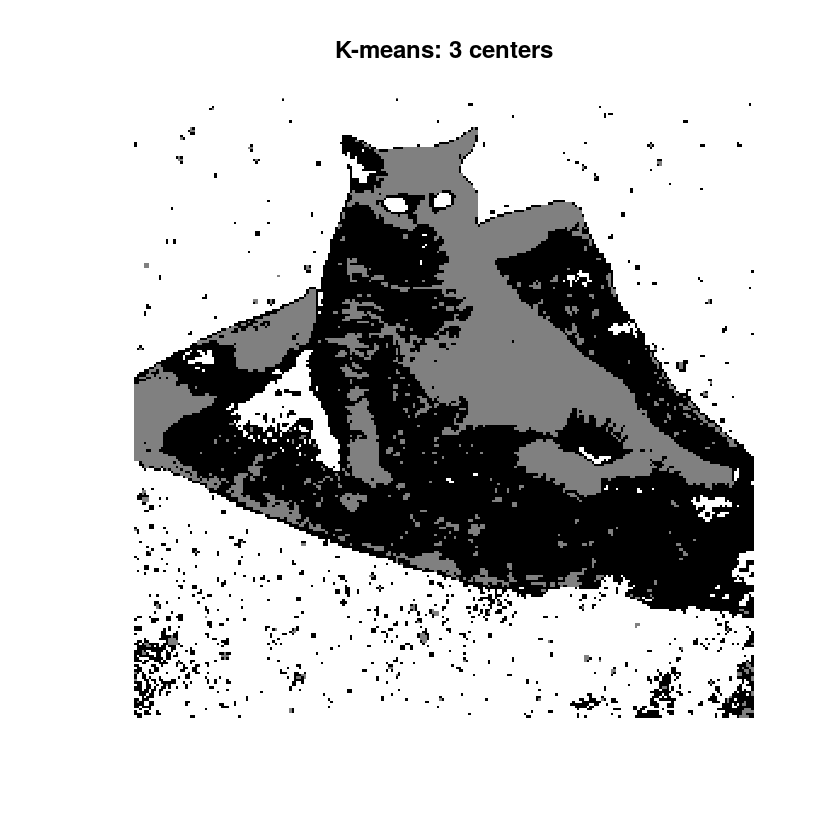

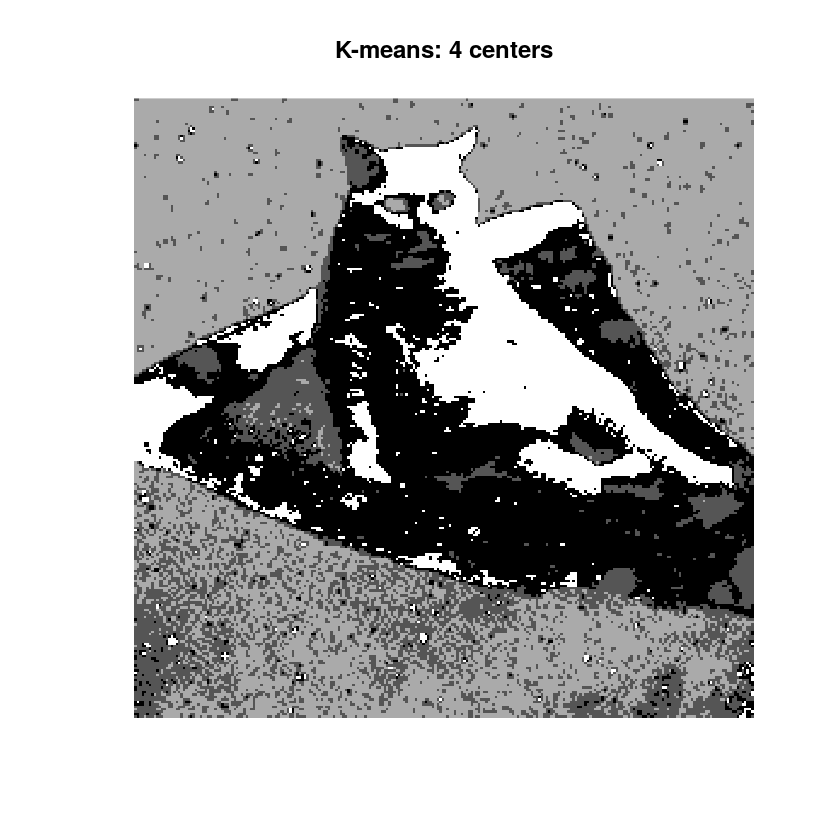

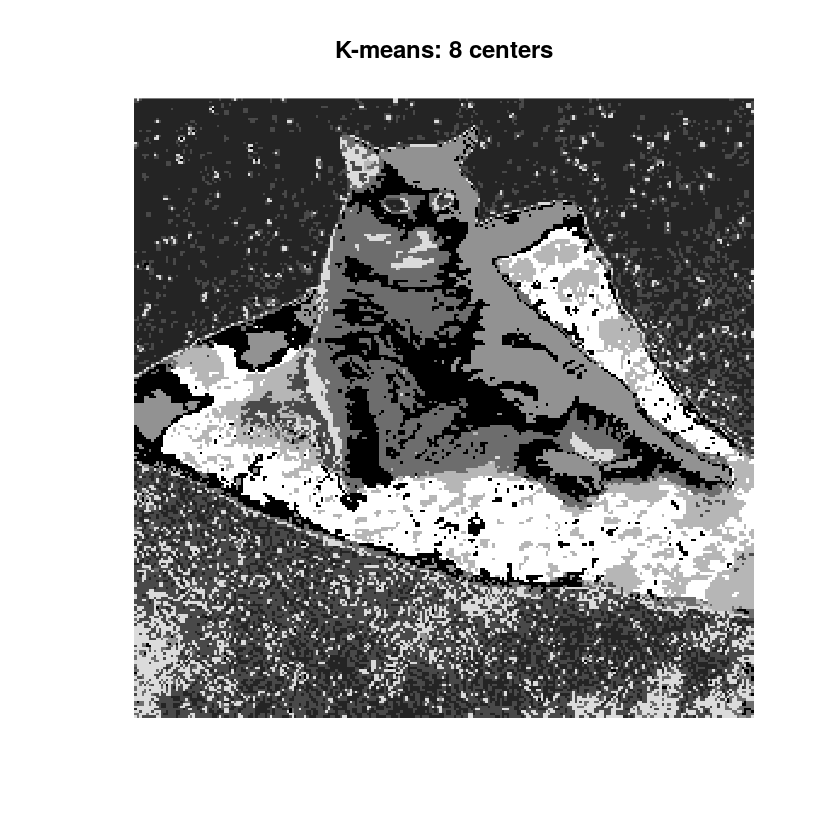

In [9]:
alternatives <- c(2, 3, 4, 8)

for (alt in alternatives) {
    km <- kmeans(colors, centers=alt)
    plot(pixmapGrey(
        km$cluster,
        nrow=pic_dim
    ), main=sprintf("K-means: %d centers", alt))
}

The plots have been made with grey color maps, therefore each shade of gray represents one class (per image).

We can see that it is relatively easy to isolate Felix on his pizza from the background $-$ apart from the stars $-$ with 2 clusters. However, it is difficult to isolate the cat from the pizza itself, since the colors have been mixed up carefully. To try to have relatively isolated pizza toppings, we need to use 8 clusters.

### 4.2 Hierarchical clustering

This method outputs a _dendogram_ that is used to determine graphically the number of classes to be used for clustering. By testing how it is possible to combine every pair of pixel given a metric it determines which grouping can be made like a decision tree where the trunk would be _everything together_ and each leaf would be _a pixel alone_.

However it needs to compute the evaluation of the metric for all pairs of pixels in the image which may take forever on a picture with high resolution or even be impossible since it has to allocate a lot of RAM.

Therefore one solution is to reduce the quality of the picture, by keeping one in four pixels only for example.

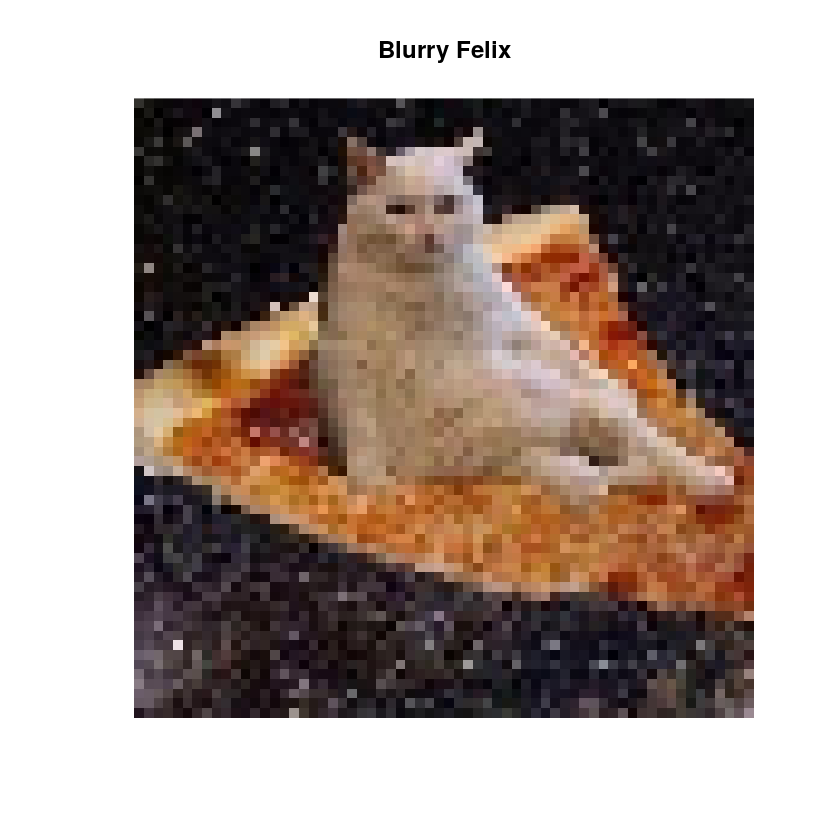

In [10]:
simplified_p <- picture[seq(1, pic_dim, by=4),seq(1, pic_dim, by=4)]

plot(simplified_p, main='Blurry Felix')

Now that the image has a lower resolution, which makes it look blurry, we can clusterize and display the output.

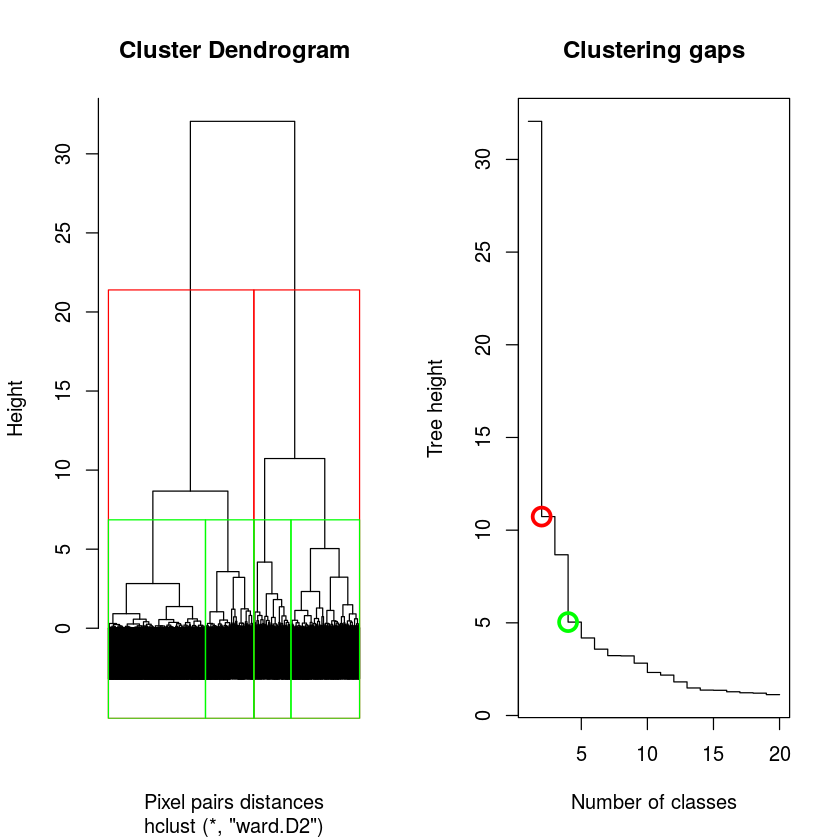

In [11]:
simplified_c <- data.frame(
    red=as.vector(simplified_p@red),
    green=as.vector(simplified_p@green),
    blue=as.vector(simplified_p@blue)
)

# Compute distances
distances <- dist(simplified_c)
# Clusterize
cah <- hclust(distances, method='ward.D2')

par(mfrow=c(1, 2))
plot(cah, labels=FALSE, xlab='Pixel pairs distances')
rect.hclust(cah, k=2, border='red')
rect.hclust(cah, k=4, border='green')

inertia <- sort(cah$height, decreasing=TRUE)
plot(
    inertia[1:20],
    type='s',
    xlab='Number of classes',
    ylab='Tree height',
    main='Clustering gaps'
)
points(
    c(2, 4),
    inertia[c(2, 4)],
    col=c('red', 'green'),
    cex=2,
    lwd=3
)

This shows a big gap between 1 and 2 classes, which means that it is easy to identify 2 elements on the picture. This probably refers to the cat on its pizza and the space that we already saw with the K-means. 

Then we see a second bigger gap $-$ yet smaller than the first one $-$ between 3 and 4 classes which means that dividing into 4 classes seems reasonable enough : the cat, the space, the pizza toppings and its crust ? After looking at the K-means clusters with 4 centers, it seems more complicated than that since the cat has a _brownish_ color that is close to the one of the crust, especially in his darker spots.

Finally, using more than 4 classes does not seem to improve significantly the clustering.

## 5 Principal component analysis

The principal component analysis aims to determine how to combine the orientation vectors of a linear vector-space in order to reduce the standard deviation of the data. In order words, it tries to find to best new orientation vectors so that the norm (or length) of the scattered data (vectors) is the smallest possible. It then outputs what is called the **principal components** which refer to the general directions of the data in the vector-space, and gives the part of the deviation each direction holds.

In our example, since there are 3 directions (red, blue and green), it is aiming at reducing the picture to a simpler combination of those colors. Let us see the PCA result and the influence of each component on the standard deviation and the projection of the data pixels and colors in the $Comp_1 \times Comp_2$ space.

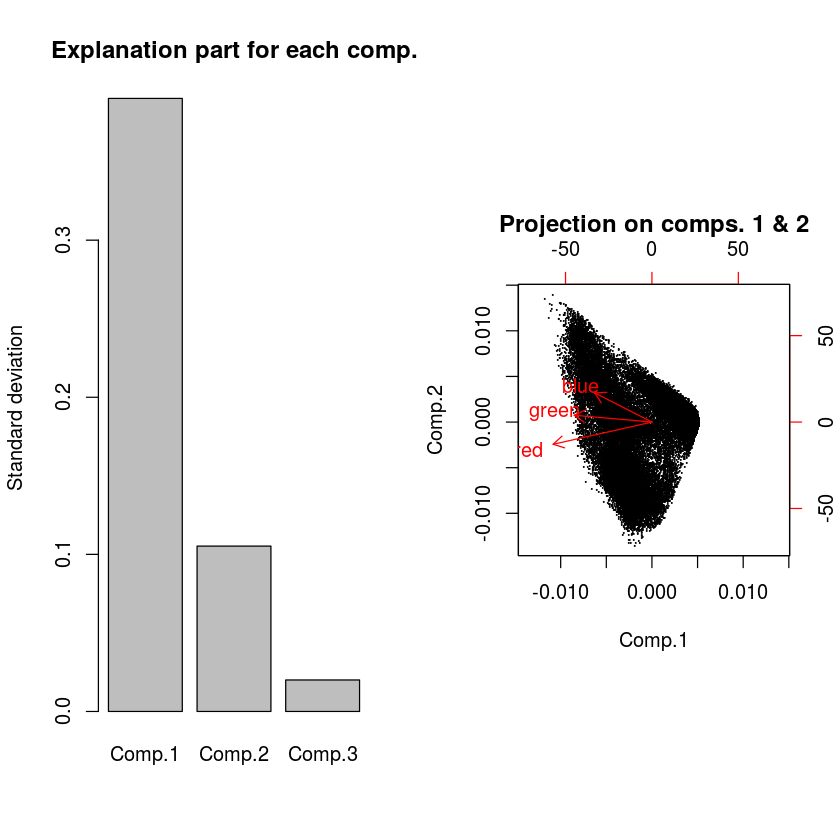

In [12]:
ACP = princomp(colors, scale=F)
par(mfrow=c(1, 2))
barplot(
    ACP$sdev,
    ylab='Standard deviation',
    main='Explanation part for each comp.'
)
biplot(
    ACP,
    xlabs=rep("·", nrow(colors)),
    main='Projection on comps. 1 & 2'
)

It is clear that the bigger part of the colors distribution is explained by the first component (roughly $80\%$) whereas the third one is almost useless. In fact, the first component holds the general colors and the forms, and the second one holds the color shades.

Moreover, while looking at the _biplot_, it is clear that the colors are correlated because they have relatively similar directions.

Finally, to see the relative impact of each principal direction on the image itself, we can try to rebuild the image from the components.

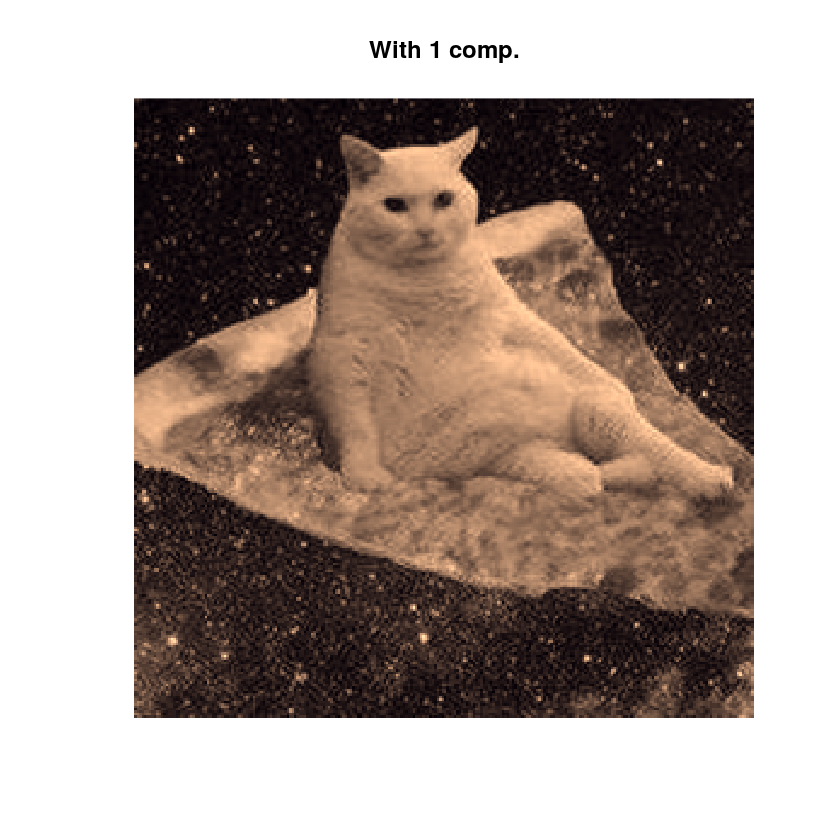

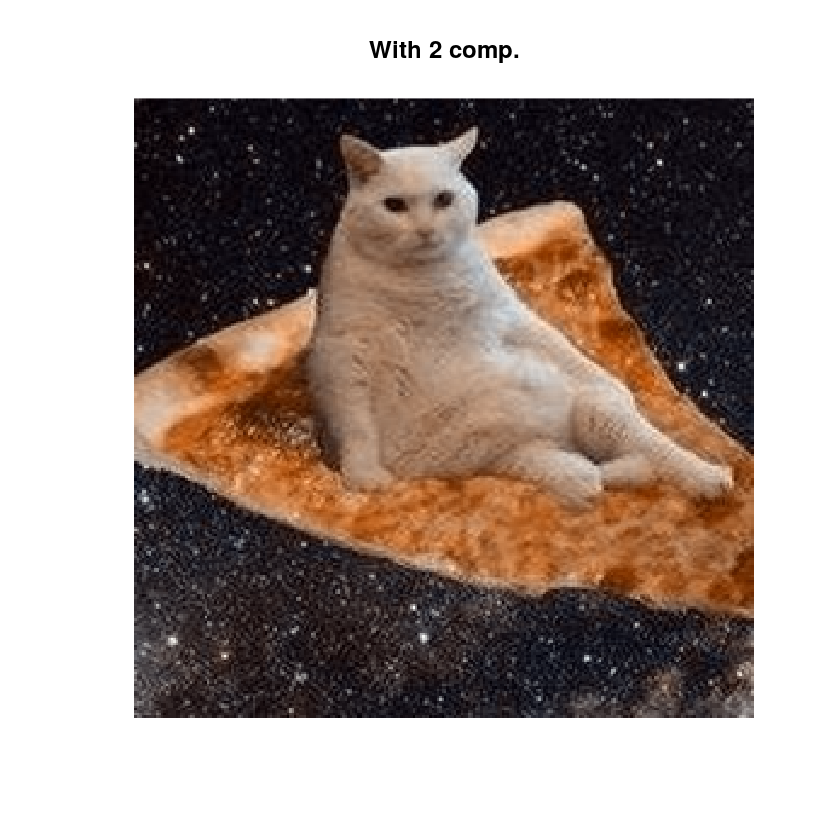

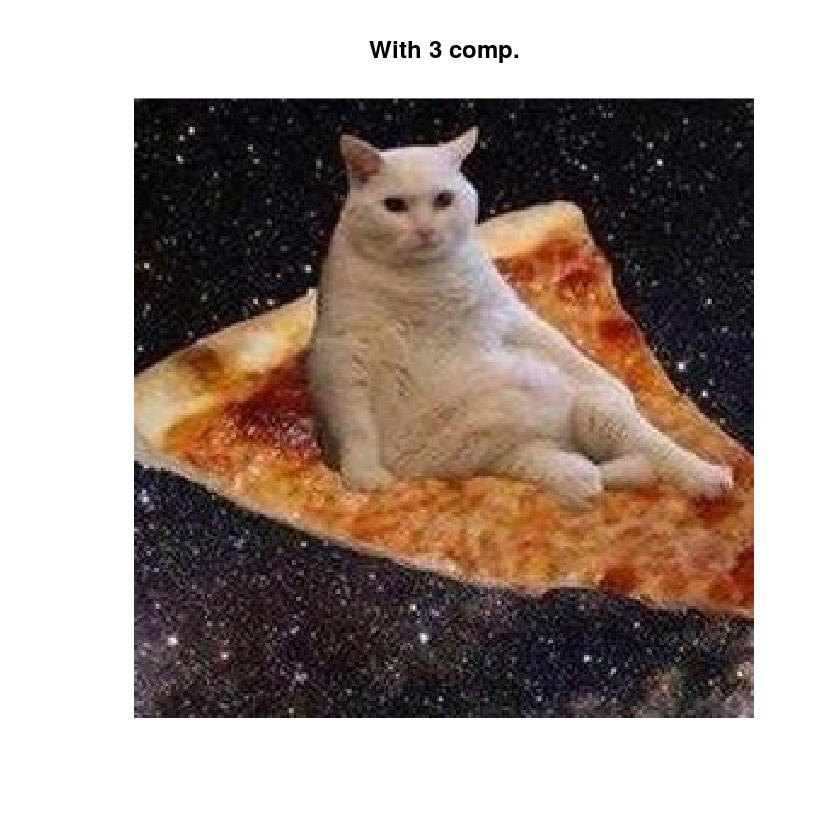

In [13]:
comps = c(1, 2, 3) 
# Use PCA function rather than prcomp/princomp
pca = PCA(colors, graph=FALSE, scale.unit=FALSE)
for (comp in comps) {
    reconstruction <- reconst(pca, ncp=comp)
    img <- picture
    # Fill the image with reconstruction
    img@red <- matrix(reconstruction[,1], nrow(picture@red), ncol(picture@red))
    img@green <- matrix(reconstruction[,2], nrow(picture@green), ncol(picture@green))
    img@blue <- matrix(reconstruction[,3], nrow(picture@blue), ncol(picture@blue))
    # Filter out some side effects by keeping everything in [0, 1]
    img@red[img@red < 0] <- 0
    img@green[img@green<0] <- 0
    img@blue[img@blue < 0] <- 0
    img@red[img@red > 1] <- 1
    img@green[img@green > 1] <- 1
    img@blue[img@blue > 1] <- 1
    # Plot
    plot(img, main=sprintf('With %s comp.', comp))
}

We can therefore conclude that the first component holds the mostly the brightness, and a mix of colors that could be interpreted as the general color of the picture. The second one then just adds the shades and the third one is almost useless (in this case).

Such a process can be used to compress images before sending them. By doing a PCA, we go down from 3 vectors (of the size of the image) to 2 vectors + the principal components directions, without losing much of the picture itself as we saw just before.

## 6 References

<ul style="list-style:none; padding: 0;">
<li>[1] [Tout sur le dendogramme - Joseph Larmarange](http://larmarange.github.io/analyse-R/classification-ascendante-hierarchique.html)
<li>[2] [Classification automatique sous R, CAH et K-Means - Ricco Rakotomalala](https://eric.univ-lyon2.fr/~ricco/cours/didacticiels/R/cah_kmeans_avec_r.pdf)
</ul>